### SHIP DETECTION USING SENTINEL 2 SATELLITE IMAGES

WEkEO is the EU Copernicus DIAS (Data and Information Access Service) reference service for environmental data, virtual processing environments and skilled user support.

WEkEO offers access to a variety of data, including different parameters sensored from Sentinel-1, Sentinel-2 and Sentinel-3. It further offers access to climate reanalysis and seasonal forecast data.

The Harmonised Data Access (HDA) API, a REST interface, allows users to subset and download datasets from WEkEO.

In the current Jupyter notebook we will build a simple yet powerful workflow to count the number of ships parked in a harbour.

<img src='./img/Merged_documen_w.png' alt='' align='centre' width='20%'></img>

<!-- ![Merged_documen_w.png](attachment:Merged_documen_w.png) -->




In [1]:
import os
import matplotlib.pyplot as plt               # create visualizations
import numpy as np                            # scientific comupting
import json                                   # JSON encoder and decoder
import glob
import time                                   # time assessment
import pandas as pd
import folium                                 # visualization
from folium import plugins                    # visualization
from folium.plugins import MiniMap, Draw, Search # visualization

from IPython.display import display           # visualization
pd.set_option('display.max_columns', None)
from datetime import date
from basemaps import basemaps
import geopandas as gpd
from shapely.geometry import Point, Polygon

import ipywidgets
from IPython.display import display
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import geopandas
import datetime
import configparser

import os
import sys
import json
import time
import base64
from IPython.core.display import HTML

import requests
import warnings
warnings.filterwarnings('ignore')

# Load helper functions
from hda_api_functions import *

<h1> Credentials Configuration </h1>

In [2]:
# your WEkEO API username and password (needs to be in '  ')
user_name = ''
password = ''

api_key = generate_api_key(user_name, password)
display(HTML('Your API key is: <b>'+api_key+'</b>'))

# Declare Dataset id. In this application we area using Sentinel 2 Level 2A products only.
dataset_id ="EO:ESA:DAT:SENTINEL-2:MSI"

# Enter here the directory path where you want to download the data to.
download_dir_path = os.getcwd() + "\\data"

hda_dict = init(dataset_id, api_key, download_dir_path)

hda_dict = get_access_token(hda_dict)

# Accept Terms and Conditions (if applicable)
hda_dict = acceptTandC(hda_dict)
 

Getting an access token. This token is valid for one hour only.
Success: Access token is 52ae1218-e12e-310f-8f3a-a57fbe7e1d38
Copernicus_General_License Terms and Conditions already accepted



<h1> Select the Area of Interest </h1>


In [3]:
# create map
f = folium.Figure(height=500)
m = folium.Map(location=[34.952743, 33.152671], zoom_start=4, control_scale=True).add_to(f)

# add custom basemap
basemaps['Google Satellite Hybrid'].add_to(m)

# add a layer control panel to the map
m.add_child(folium.LayerControl())

# add minimap
m.add_child(MiniMap(tile_layer=basemaps['Google Satellite'], position='bottomright'))

# add draw control
draw = Draw(export=True, filename='AOI_manual_%s.geojson' % str(date.today()), draw_options={'polyline': False, 'circle': False, 'marker': False, 'circlemarker': False})
draw.add_to(m)

# MousePosition
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(position='topright',separator=' | ',empty_string='NaN',lng_first=True,num_digits=20,prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

# display map
updater = display(f, display_id='m')

<h1> Select a Date Range </h1>

In [4]:

start_date = widgets.DatePicker(
    description='Start Sensing',
    disabled=False
)
end_date = widgets.DatePicker(
    description='End Sensing',
    disabled=False
)

instructions = ipywidgets.widgets.HTML('Define the sensing period time range:')
display(instructions)

widgets.HBox([start_date, end_date])



HTML(value='Define the sensing period time range:')

<h1> Select Cloud Cover Percentage </h1>

In [5]:
cloud = widgets.IntSlider(value=10,min=0,max=100,step=10, description="Percentage")
display(cloud)

IntSlider(value=10, description='Percentage', step=10)

In [6]:
# Load geometry from geojson file 
gjson = gpd.read_file("AOI_manual_2022-08-03.geojson")
geomg = gjson["geometry"][0].bounds
geo2 = gjson["geometry"][0]

n1 = geomg[0] + 0.00000011111111
n2 = geomg[1] + 0.000000111111111
n3 = geomg[2] + 0.00000011111111
n4 = geomg[3] + 0.00000011111111

start_date2 = str(start_date.value.year) + str("-")+ str(start_date.value.month) +str("-") + str(start_date.value.day) 
end_date2 = str(end_date.value.year)+ str("-") + str(end_date.value.month) + str("-") + str(end_date.value.day)

print(n1, n2, n3, n4)
print()

32.99816611111111 34.62982511111111 33.167802111111115 34.70888711111111


In [8]:
data = {
  "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        n1, 
        n2,
        n3, 
        n4  
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": start_date2 + "T00:00:00.000Z",
      "end": end_date2 + "T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": "LEVEL2A"
    }
  ],
  "stringInputValues": [
    {
      "name": "cloudCover",
      "value": str(cloud.value)
    }
  ]
}


In [22]:
print(data)

{'datasetId': 'EO:ESA:DAT:SENTINEL-2:MSI', 'boundingBoxValues': [{'name': 'bbox', 'bbox': [32.99816611111111, 34.62982511111111, 33.167802111111115, 34.70888711111111]}], 'dateRangeSelectValues': [{'name': 'position', 'start': '2022-6-10T00:00:00.000Z', 'end': '2022-6-30T00:00:00.000Z'}], 'stringChoiceValues': [{'name': 'processingLevel', 'value': 'LEVEL2A'}], 'stringInputValues': [{'name': 'cloudCover', 'value': '10'}]}


In [9]:
print(data2)

{'datasetId': 'EO:ESA:DAT:SENTINEL-2:MSI', 'boundingBoxValues': [{'name': 'bbox', 'bbox': [22.73014726335307, 39.413033997865874, 22.92517137859164, 39.56249325834462]}], 'dateRangeSelectValues': [{'name': 'position', 'start': '2022-07-20T00:00:00.000Z', 'end': '2022-07-31T00:00:00.000Z'}], 'stringChoiceValues': [{'name': 'processingLevel', 'value': 'LEVEL2A'}], 'stringInputValues': [{'name': 'cloudCover', 'value': '10'}]}


In [11]:
data2 = {
  "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        22.73014726335307,
        39.413033997865874,
        22.92517137859164,
        39.56249325834462
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": "2022-07-20T00:00:00.000Z",
      "end": "2022-07-31T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": "LEVEL2A"
    }
  ],
  "stringInputValues": [
    {
      "name": "cloudCover",
      "value": "10"
    }
  ]
}


In [12]:
# Initiate the request by assigning a job ID
hda_dict = get_job_id(hda_dict, data2)

# Build list of file names to be ordered and downloaded
hda_dict = get_results_list(hda_dict)

# Create an `order ID` for each file to be downloaded
hda_dict = get_order_ids(hda_dict)

# Download requested data
hda_dict = download_data(hda_dict)

Query successfully submitted. Job ID is OVFUqyjhfJrgrYHO5ofko_ehtkY
Query successfully submitted. Status is running
Query successfully submitted. Status is completed
************** Results *******************************
{
    "content": [
        {
            "downloadUri": null,
            "filename": "S2B_MSIL2A_20220727T091559_N0400_R093_T34SFJ_20220727T105553.zip",
            "order": null,
            "productInfo": {
                "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
                "product": "S2B_MSIL2A_20220727T091559_N0400_R093_T34SFJ_20220727T105553.SAFE",
                "productEndDate": "2022-07-27T09:15:59.024000Z",
                "productStartDate": "2022-07-27T09:15:59.024000Z"
            },
            "size": 1143325053,
            "url": "1abada95-dd6c-5339-93cb-06cc34584936/S2B_MSIL2A_20220727T091559_N0400_R093_T34SFJ_20220727T105553.zip"
        },
        {
            "downloadUri": null,
            "filename": "S2A_MSIL2A_20220722T092041_N0400_R0

KeyboardInterrupt: 

In [30]:
ls

 Volume in drive D is Data
 Volume Serial Number is B407-8013

 Directory of D:\ë?à????åæ??\Wekeo\Weke_Competition\data

08/03/2022  11:05 PM    <DIR>          .
08/03/2022  11:05 PM    <DIR>          ..
02/15/2022  12:27 PM       703,426,309 S2A_MSIL1C_20180129T083211_N0206_R021_T36SWD_20180129T122059.zip
               1 File(s)    703,426,309 bytes
               2 Dir(s)  201,334,247,424 bytes free


In [31]:
import zipfile
with zipfile.ZipFile("D:\\Διαγωνισμοί\\Wekeo\\Weke_Competition\\data\\S2A_MSIL1C_20180129T083211_N0206_R021_T36SWD_20180129T122059.zip", 'r') as zip_ref:
    zip_ref.extractall("D:\\Διαγωνισμοί\\Wekeo\\Weke_Competition\\data\\")

In [29]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
from pyproj import Proj
from math import floor, ceil
from rasterio.mask import mask
%matplotlib inline

#import bands as separate 1 band raster

imagePath = str("D:\\Διαγωνισμοί\\Wekeo\\Weke_Competition\\data\\S2A_MSIL1C_20180129T083211_N0206_R021_T36SWD_20180129T122059.SAFE\\GRANULE\\L1C_T36SWD_A013603_20180129T083908\\IMG_DATA\\")

band3 = imagePath + "T36SWD_20180129T083211_B03.jp2" #green
band8 = imagePath+ "T36SWD_20180129T083211_B08.jp2"  #nir

###################################################################################################################

def longlat2window(lon, lat, dataset):
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
    p = Proj(dataset.crs)
    t = dataset.transform
    xmin, ymin = p(lon[0], lat[0])
    xmax, ymax = p(lon[1], lat[1])
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return Window.from_slices(rows=(floor(row_max), ceil(row_min)), cols=(floor(col_min), ceil(col_max)))


######################################################################################################################

#open the bands
with rasterio.open(band3) as green:
    window = longlat2window((33.05608383610904, 33.37416014306592), (34.57339942311068, 34.67132013966185), green)
    GREEN = green.read(1, window=window).astype(float)
    
with rasterio.open(band8) as nir:
    window = longlat2window((33.05608383610904, 33.37416014306592), (34.57339942311068, 34.67132013966185), nir)
    NIR = nir.read(1, window=window).astype(float)

print(type(NIR))
print(type(GREEN))

# # compute the ndwi - Sentinel-2 NDWI = (B03 - B08) / (B03 + B08)
ndwi = (GREEN - NIR) / (GREEN + NIR)
print(ndwi.min(), ndwi.max())



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
-0.36515912897822445 0.5954415954415955


In [12]:
type(band8)

rasterio.io.DatasetReader

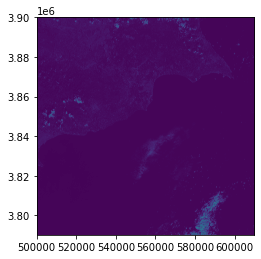

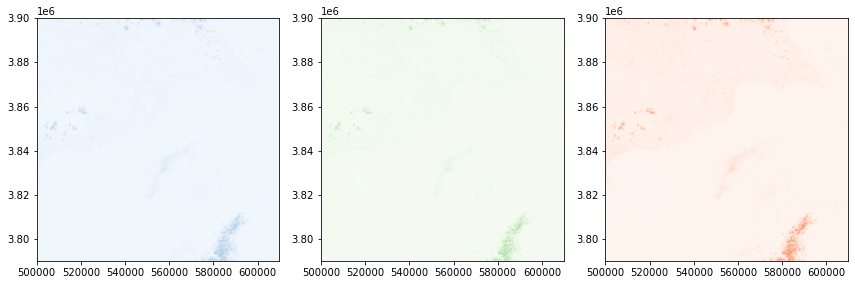

In [35]:
#number of raster bands
band4.count
#number of raster columns
band4.width
#number of raster rows
band4.height
#plot band 
plot.show(band4)

#type of raster byte
band4.dtypes[0]
#raster sytem of reference
band4.crs
#raster transform parameters
band4.transform
#raster values as matrix array
band4.read(1)

#multiple band representation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()
                
# #export true color image
# trueColor = rasterio.open('../Output/SentinelTrueColor2.tiff','w',driver='Gtiff',
#                          width=band4.width, height=band4.height,
#                          count=3,
#                          crs=band4.crs,
#                          transform=band4.transform,
#                          dtype=band4.dtypes[0]
#                          )
# trueColor.write(band2.read(1),3) #blue
# trueColor.write(band3.read(1),2) #green
# trueColor.write(band4.read(1),1) #red
# trueColor.close()
# src = rasterio.open(r"../Output/SentinelTrueColor2.tiff", count=3)
# plot.show(src)
                
# #export false color image
# falseColor = rasterio.open('../Output/SentinelFalseColor.tiff', 'w', driver='Gtiff',
#                           width=band2.width, height=band2.height,
#                           count=3,
#                           crs=band2.crs,
#                           transform=band2.transform,
#                           dtype='uint16'                   
#                          )
# falseColor.write(band3.read(1),3) #Blue
# falseColor.write(band4.read(1),2) #Green
# falseColor.write(band8.read(1),1) #Red
# falseColor.close()
# #generate histogram
# trueColor = rasterio.open('../Output/SentinelTrueColor2.tiff')
# plot.show_hist(trueColor, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

In [36]:
https://hatarilabs.com/ih-en/sentinel2-images-explotarion-and-processing-with-python-and-rasterio

1


In [ ]:
#import required libraries
import os
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
#get band names
bandPath = '../S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/'
bandNames = os.listdir(bandPath)
bandNames


['T18LUM_20200917T151709_B01.jp2',
 'T18LUM_20200917T151709_B02.jp2',
 'T18LUM_20200917T151709_B03.jp2',
 'T18LUM_20200917T151709_B04.jp2',
 'T18LUM_20200917T151709_B05.jp2',
 'T18LUM_20200917T151709_B06.jp2',
 'T18LUM_20200917T151709_B07.jp2',
 'T18LUM_20200917T151709_B08.jp2',
 'T18LUM_20200917T151709_B09.jp2',
 'T18LUM_20200917T151709_B10.jp2',
 'T18LUM_20200917T151709_B11.jp2',
 'T18LUM_20200917T151709_B12.jp2',
 'T18LUM_20200917T151709_B8A.jp2',
 'T18LUM_20200917T151709_TCI.jp2']

#import area of interest as Fiona geometry
aoiFile = fiona.open('../shp/AOI.shp')
aoiGeom = [aoiFile[0]['geometry']]


#clip one raster B01
bandName = bandNames[0]
rasterPath = os.path.join(bandPath,bandName)
rasterBand = rasterio.open(rasterPath)
outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
outMeta = rasterBand.meta
outMeta.update({"driver": 'JP2OpenJPEG',
                 "height": outImage.shape[1],
                 "width": outImage.shape[2],
                 "transform": outTransform})
outRaster = rasterio.open("../rst/"+bandName, "w", **outMeta) 
outRaster.write(outImage)
outRaster.close()


#plot original and clipped rasters
bandZero = rasterio.open("../rst/"+bandName,'r')
fig, ax = plt.subplots(figsize=(16,16))
show(rasterBand, cmap='Blues', ax=ax)
show(bandZero, cmap='viridis', ax=ax)
ax.set_ylim(rasterBand.bounds.bottom,rasterBand.bounds.top)
ax.set_xlim(rasterBand.bounds.left,rasterBand.bounds.right)
plt.show()
bandZero.close()


#clip all rasters
for band in bandNames:
    rasterPath = os.path.join(bandPath,band)
    rasterBand = rasterio.open(rasterPath)
    outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
    outMeta = rasterBand.meta
    outMeta.update({"driver": 'JP2OpenJPEG',
                 "height": outImage.shape[1],
                 "width": outImage.shape[2],
                 "transform": outTransform})
    outPath = os.path.join('../rst',band)
    outRaster = rasterio.open(outPath, "w", **outMeta) 
    outRaster.write(outImage)
    outRaster.close()

In [ ]:
https://hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial